In [ ]:
#demand.py
'''
Customer arrival simulation: nonhomogeneous poisson process
Customer arrival follows a nonhomogeneous poisson process for each day, and we know that customers are likely to purchase more orange in winter and purchase less in summer.
lambda(t) = -5*sin(2*pi*x/365) + 10

Each arrival is willing to buy x units of orange, which follows a discrete uniform distribution
U(0,  int(-price*0.05 + freshness*(50-price)/300))
'''
import numpy as np


class Customers(object):

    def __init__(self, seed=None, demand_attr=(-0.05, 50, 300), arrival_attr=(30, 2, 2)):
        self.seed = seed
        self.random_state = np.random.RandomState(seed=seed)
        self.demand_attr = demand_attr
        self.arrival_attr = arrival_attr

    def demand_function(self):
        d, e, f = self.demand_attr
        return lambda price, freshness: np.ceil(d * price + freshness * e / f)

    def get_demand(self, price, freshness):
        max_demand = self.demand_function()(price, freshness)
        max_demand = max_demand * (max_demand > 0)
        if max_demand == 0:
            return 0
        else:
            demand = self.random_state.randint(0, max_demand)
            return demand

    def arrival_function(self):
        a, b, c = self.arrival_attr
        return lambda t: a * (-np.sin(t * b * np.pi / 365)) + c

    def get_arrival(self, T=365):
        all_time = np.linspace(0, T, 1000)
        arrival_func = self.arrival_function()
        max_lambda = max(arrival_func(all_time))

        t = -1 / max_lambda * np.log(self.random_state.rand())
        arrival_time = []
        while t < T:
            if self.random_state.rand() < arrival_func(t) / max_lambda:
                arrival_time.append(t)
            inter_arrival = -1 / max_lambda * np.log(self.random_state.rand())
            t += inter_arrival

        return arrival_time


if __name__ == "__main__":
    customers = Customers(seed=0)
    price = 30
    freshness = 60
    print(customers.get_demand(price, freshness))

    print(customers.get_arrival())

5
[0.5584028366508075, 0.6613893066220123, 0.7230121343925503, 0.876382227150901, 1.4078940177564505, 1.9176054596818197, 2.589768419962758, 178.99184429583778, 180.46998728424614, 181.28517484833193, 181.7723709734683, 182.01446547813293, 183.9537521153952, 184.06041721757828, 184.06457918042335, 184.55294194133648, 184.75207321492533, 184.8321770668876, 184.86858425120008, 185.0874141729892, 185.49801231311707, 186.38277199959717, 186.89428157640904, 186.92166512957266, 187.18239915957875, 187.5791461479109, 188.04658392615536, 188.1644149168871, 188.6317511177826, 188.65680999082178, 188.7334350143825, 188.79282023486178, 188.84987317766306, 188.88745923209973, 189.21925101695675, 189.4816806026765, 189.62345502788946, 190.01240204129618, 190.11286438978817, 190.133696581671, 190.48551587989076, 190.82774288753274, 191.1643537492613, 191.25622316184234, 191.3545664117948, 191.67176790604051, 191.708674533765, 191.76937698817977, 191.8391457606753, 191.92412337976208, 192.10261624703

In [ ]:
#exception.py
!pip install simpy

import simpy

class SelfDefinedException(simpy.SimPyException):
    pass

In [ ]:
#hurricane.py

'''
we assume the arrival of hurricane follows homogeneous poisson process
and the lambda for each month is the average occurance of each month since 1950 until 2009
'''
import requests
import numpy as np
import pandas as pd
from io import StringIO


class Hurricane(object):
    """
    this class provide all hurricane arrivals for a year,
    acompany with the damage level as a list of tuple
    please use `get_all_arrival()` as the main function

    Args:
        seed: seed generator

    Returns:
        list of tuple: [(arrival date, damage level)]

        the arrival date is the time within t=0 and t=365
        the damage level represents percentage of orange selling price change
    """

    link = 'https://psl.noaa.gov/data/timeseries/monthly/Hurricane/hurr.num.data'
    rs = requests.get(link)
    file = StringIO(str(rs.content).split("2009")[1].split("-999")[0].replace("\\n", '\n'))
    data = pd.read_table(file, sep='\s+', header=None, index_col=0)

    def __init__(self, seed=None):
        self.month_freq = self.data.mean(axis=0).div(30).to_dict()
        self.seed = seed

    @staticmethod
    def generate_arrival(lmbda, T=30, seed=None):
        random_state = np.random.RandomState(seed=seed)
        n = random_state.poisson(lam=T * lmbda, size=1)
        arrivals = random_state.uniform(0, T, size=n)
        arrivals = np.sort(arrivals)
        return arrivals

    def hurricane_simulation(self):
        result = []
        for k, v in self.month_freq.items():
            # generate arrival according to each month's lambda
            a = self.generate_arrival(v, T=30, seed=self.seed)
            # convert to our time scope, t=0 is 1/1, t=365 is 12/31
            a += 30 * list(range(12))[k - 1]
            result.extend(a)
        return result

    @staticmethod
    def generate_damage_level(low=0, high=1, seed=None, size=1):
        random_state = np.random.RandomState(seed=seed)
        return random_state.uniform(low=low, high=high, size=size)

    def get_all_arrival(self):
        arrivals = self.hurricane_simulation()
        damage = self.generate_damage_level(seed=self.seed, size=len(arrivals))
        return list(zip(arrivals, damage))


if __name__ == "__main__":
    x = Hurricane()
    # print(x.hurricane_simulation())
    print(x.get_all_arrival())

    y = Hurricane(seed=0)
    # print(y.hurricane_simulation())
    print(y.get_all_arrival())

[(183.09110410406007, 0.3460842019269307), (213.48174021940684, 0.7458508635253381), (214.6104477203167, 0.9175006569429749), (233.0250458828345, 0.4562241546468262), (245.89984748270982, 0.498126316436067), (252.69872872764, 0.9084721542205101), (255.79853434570487, 0.8642626454418585), (257.8504479381052, 0.6251898397356417), (266.6487891996451, 0.7923128267392359), (269.6244051283019, 0.5390861003071741), (286.0548757599502, 0.8118796277973661), (303.63576108853505, 0.39428055809816864)]
[(222.70964398016713, 0.5488135039273248), (223.12761633788077, 0.7151893663724195), (229.3768233919997, 0.6027633760716439), (253.12761633788077, 0.5448831829968969), (259.37682339199966, 0.4236547993389047), (266.75319002346237, 0.6458941130666561), (268.90988281503087, 0.4375872112626925), (282.70964398016713, 0.8917730007820798), (286.3464954899069, 0.9636627605010293)]


In [ ]:
#inventory.py

'''
inventory memangement:
Freshness = 100 if the orange is stored within 5 days,
60 if the orange is stored between 6~10 days,
20 if the orange is stored between 11~15 days,
when the orange is stored over 16 days, we are not allowed to sell it.
'''
from collections import OrderedDict


class Inventory(object):
    def __init__(self, size=120, debug=False):
        self.size = size
        self.inventory = OrderedDict()
        self.debug = debug

    def get_current_volume(self):
        return sum(list(self.inventory.values()))

    def _check(self):
        if self.get_current_volume() <= self.size:
            return True
        else:
            return False

    def inventory_process(self, env, result):
        while True:
            yield env.timeout(1)
            current_time = env.now
            self.decay(current_time, result)
            if not self._check:
                raise SelfDefinedException("the volume of orange is larger than our inventory size")
            if self.debug:
                print(env.now, self.inventory)

    def refill(self, time, amount):
        # the newest stocks will be the last element
        if isinstance(time, float):
            time = int(time)
        if self.get_current_volume() + amount <= self.size:
            self.inventory[time] = amount
        else:
            raise SelfDefinedException("the volume of orange will be larger than our inventory size")

    def decay(self, current_time, result):
        # throw away all items stored over 16 days
        # FIFO: first in first out
        keys = list(self.inventory.keys())
        if len(keys) > 0:
            while keys:
                first_key = keys.pop(0)
                if current_time - first_key > 15:
                    if self.debug:
                        print('The orange refill at t=%.2f are decayed (over 15 days), and %.2f oranges are removed' % (
                        first_key, self.inventory[first_key]))
                    decay = self.inventory.popitem(last=False)
                    result['decayList'].append(decay)

    @staticmethod
    def transfer_freshness(x):
        if x <= 5:
            return 100
        elif x <= 10:
            return 60
        elif x <= 15:
            return 20
        else:
            return 0

    def get_freshness(self, current_time):
        ans = 0
        total_amount = 0
        for t, v in self.inventory.items():
            total_amount += v
            ans += self.transfer_freshness(current_time - t) * v

        if total_amount > 0:
            return ans / total_amount
        else:
            return 0

    def selling(self, amount):
        keys = list(self.inventory.keys())
        key_index = 0

        while amount and self.get_current_volume() > 0:
            first_key = keys[key_index]

            if self.inventory[first_key] > amount:
                self.inventory[first_key] -= amount
                amount = 0
            else:
                amount -= self.inventory[first_key]
                del self.inventory[first_key]
                key_index += 1

        if amount and self.debug:
            print('The request is larger than our inventory level')


In [ ]:
#pricing.py

'''
Pricing strategy:
Constant price (e.g. 20 per orange)
Linear pricing strategy: a linear equation of inventory level
(e.g. price = -0.75*current_inventory + 30)
'''

class Price(object):

    def __init__(self, max_price=30):
        self.max_price = max_price


    def constant_price(self, constant_price=None, *args, **kwargs):
        if constant_price:
            return constant_price
        else:
            return self.max_price * 2/3


    def linear_price(self, current_inventory, a=-0.25, *args, **kwargs):
        return a*current_inventory + self.max_price


if __name__ == "__main__":
    import numpy as np
    price = Price(30)
    print(price.constant_price(25))
    print(price.constant_price())

    current_inventory = np.arange(0, 120, 1)
    print(price.linear_price(current_inventory))

25
20.0
[30.   29.75 29.5  29.25 29.   28.75 28.5  28.25 28.   27.75 27.5  27.25
 27.   26.75 26.5  26.25 26.   25.75 25.5  25.25 25.   24.75 24.5  24.25
 24.   23.75 23.5  23.25 23.   22.75 22.5  22.25 22.   21.75 21.5  21.25
 21.   20.75 20.5  20.25 20.   19.75 19.5  19.25 19.   18.75 18.5  18.25
 18.   17.75 17.5  17.25 17.   16.75 16.5  16.25 16.   15.75 15.5  15.25
 15.   14.75 14.5  14.25 14.   13.75 13.5  13.25 13.   12.75 12.5  12.25
 12.   11.75 11.5  11.25 11.   10.75 10.5  10.25 10.    9.75  9.5   9.25
  9.    8.75  8.5   8.25  8.    7.75  7.5   7.25  7.    6.75  6.5   6.25
  6.    5.75  5.5   5.25  5.    4.75  4.5   4.25  4.    3.75  3.5   3.25
  3.    2.75  2.5   2.25  2.    1.75  1.5   1.25  1.    0.75  0.5   0.25]


In [ ]:
#main.py

import simpy
import collections
import numpy as np
import pandas as pd
import scipy.stats as spst

#from package import demand, pricing, inventory, hurricane

MAX_FRESHNESS = 100
MAX_PRICE = 130
MAX_INVENTORY = 200
CONSTANT_PRICE = 125
LINEAR_PRICE_BETA = -0.05
REFILL_UNIT = 50
STARTING_UNIT = 50

demand_attr = (-0.2, 100, 200)
arrival_attr = (30, 2, 60)  # (-5, 2, 10)
total_day = 365


def get_all_default_parameters():
    global MAX_FRESHNESS
    global MAX_PRICE
    global MAX_INVENTORY
    global CONSTANT_PRICE
    global LINEAR_PRICE_BETA
    global REFILL_UNIT
    global STARTING_UNIT
    global demand_attr
    global arrival_attr
    global total_day
    return {'MAX_FRESHNESS': MAX_FRESHNESS, 'MAX_PRICE': MAX_PRICE,
            'MAX_INVENTORY': MAX_INVENTORY, 'CONSTANT_PRICE': CONSTANT_PRICE,
            'LINEAR_PRICE_BETA': LINEAR_PRICE_BETA, 'REFILL_UNIT': REFILL_UNIT,
            'STARTING_UNIT': STARTING_UNIT, 'demand_attr': demand_attr,
            'arrival_attr': arrival_attr, 'total_day': total_day}


def load_orange_price(string=None, divid=2, round_float=2):
    # return processed orange future data
    if string:
        from io import StringIO
        data = pd.read_csv(StringIO(string))
    else:
        data = pd.read_csv('Orange Juice Futures Historical Data.csv')
    data.index = pd.to_datetime(data['Date'], format='%b %d, %Y')
    data = data.sort_index()
    orange_price = data['Price'].resample('1D').ffill().div(divid).round(round_float)
    orange_price = orange_price.reset_index(drop=True)
    return orange_price


def get_orange_price(df, return_origin=False, seed=None):
    # load hurricane tuples and return processed final orange price
    hurr = Hurricane(seed=seed)
    hurr_tuple = hurr.get_all_arrival()
    price_change = collections.defaultdict(int)
    for time, strike in hurr_tuple:
        time = int(time)
        for i in range(5):
            time += 1
            price_change[time] = strike
    price_change = pd.DataFrame.from_dict(price_change, orient='index', columns=['Strike'])
    df = pd.concat([df, price_change], axis=1).fillna(0)
    df['Final Price'] = df['Price'] * (1 + df['Strike'])
    return df['Final Price'] if not return_origin else df


def arrival(env, params, result):
    # simpy customers arrival process
    customers = Customers(params['seed'], params['demand_attr'], params['arrival_attr'])
    arrival_time = customers.get_arrival()

    for a in arrival_time:
        yield env.timeout(a)
        price_kwargs = {
            'current_inventory': params['inventory_class'].get_current_volume(),
            'constant_price': params['constant_price'],
            'a': params['linear_price_beta']
        }

        if params['strategy'] == 'linear':
            current_price = params['price_strategy'].linear_price(**price_kwargs)
        else:
            current_price = params['price_strategy'].constant_price(**price_kwargs)

        current_freshness = params['inventory_class'].get_freshness(int(env.now))
        current_demand = customers.get_demand(current_price, current_freshness)
        current_inventory_level = params['inventory_class'].get_current_volume()

        # storing results
        result['revenueList'].append(
            min(current_demand, current_inventory_level) * current_price
        )
        result['freshList'].append(current_freshness)
        result['demandList'].append(current_demand)
        result['inventoryVolumeList'].append(current_inventory_level)
        result['fulfillList'].append(current_demand < current_inventory_level)

        params['inventory_class'].selling(current_demand)


def refill(env, params, result):
    # simpy inventory refill process
    params['inventory_class'].refill(0, params['starting_units'])
    result['refillTimeList'].append(0)
    result['costList'].append(params['orange_price'].loc[0] * params['starting_units'])

    while True:
        yield env.timeout(1)
        if params['inventory_class'].get_current_volume() <= params['inventory_class'].size * params[
            'refill_percentage']:
            params['inventory_class'].refill(env.now, params['refill_units'])
            result['costList'].append(params['orange_price'].loc[int(env.now)] * params['refill_units'])
            result['refillTimeList'].append(env.now)


def system(orange_price, strategy='constant', refill_percentage=0.08, seed=None):
    # main simpy system environment
    global MAX_FRESHNESS
    global MAX_PRICE
    global MAX_INVENTORY
    global CONSTANT_PRICE
    global LINEAR_PRICE_BETA
    global REFILL_UNIT
    global STARTING_UNIT
    global demand_attr
    global arrival_attr
    global total_day

    inventory_class = Inventory(size=MAX_INVENTORY)
    price_strategy = Price(MAX_PRICE)
    arrival_params = {
        'strategy': strategy,
        'price_strategy': price_strategy,
        'inventory_class': inventory_class,
        'demand_attr': demand_attr,
        'arrival_attr': arrival_attr,
        'linear_price_beta': LINEAR_PRICE_BETA,
        'constant_price': CONSTANT_PRICE,
        'seed': seed
    }
    refill_params = {
        'inventory_class': inventory_class,
        'refill_percentage': refill_percentage,
        'orange_price': orange_price,
        'refill_units': REFILL_UNIT,
        'starting_units': STARTING_UNIT
    }

    result = collections.defaultdict(list)

    env = simpy.Environment()
    env.process(arrival(env, arrival_params, result))
    env.process(refill(env, refill_params, result))
    env.process(inventory_class.inventory_process(env, result))
    env.run(until=total_day)

    return result


def getAverageResult(*result_dict):
    result = collections.defaultdict(list)
    count = len(result_dict)

    for r in result_dict:
        result['Revenue'].append(sum(r['revenueList']))
        result['Cost'].append(sum(r['costList']))
        result['Profit'].append(sum(r['revenueList']) - sum(r['costList']))
        result['CustomerZeroDemand'].append(sum(np.array(r['demandList']) == 0) / len(r['demandList']))
        result['ZeroInventoryLevel'].append(
            sum(np.array(r['inventoryVolumeList']) == 0) / len(r['inventoryVolumeList']))
        result['RefillTimes'].append(len(r['refillTimeList']))
        result['NotFulfillRatio'].append(sum(~np.array(r['fulfillList'])) / len(r['fulfillList']))
        result['Freshness'].append(sum(r['freshList']) / len(r['freshList']))
        result['DecayUnits'].append(pd.DataFrame(r['decayList'], columns=['Time', 'Amount'])['Amount'].sum())

    result['avgProfit'] = np.mean(result['Profit'])
    result['avgCost'] = np.mean(result['Cost'])
    result['avgRevenue'] = np.mean(result['Revenue'])
    result['avgCustomerZeroDemand'] = np.mean(result['CustomerZeroDemand'])
    result['avgZeroInventoryLevel'] = np.mean(result['ZeroInventoryLevel'])
    result['avgRefillTimes'] = np.mean(result['RefillTimes'])
    result['avgNotFulfillRatio'] = np.mean(result['NotFulfillRatio'])
    result['avgFreshness'] = np.mean(result['Freshness'])
    result['avgDecayUnits'] = np.mean(result['DecayUnits'])

    return result


def calculateConfidenceInterval(nums, names="", alpha=0.05, round_digit=3):
    mean = np.mean(nums)
    std = np.std(nums, ddof=1)
    z_score = spst.norm.ppf(1 - alpha / 2)
    N = len(nums)

    lower = mean - z_score * std / N ** 0.5
    upper = mean + z_score * std / N ** 0.5
    print(
        '%s %.2f confidence interval: (%s, %s)' % (
        names, 1 - alpha, round(lower, round_digit), round(upper, round_digit))
    )

In [ ]:
#visualization


start_time = -2
end_time = 366
total_day = 365

MAX_FRESHNESS = 100
MAX_PRICE = 130
MAX_INVENTORY = 200
CONSTANT_PRICE = 125
LINEAR_PRICE_BETA = -0.05
demand_attr = (-0.2, 100, 200)
arrival_attr = (30, 2, 60)

In [ ]:
#pricing strategy
inventory_level = np.arange(0, MAX_INVENTORY, 1)


price_strategy = Price(max_price=MAX_PRICE)

linear = price_strategy.linear_price(inventory_level, a=LINEAR_PRICE_BETA)
constant = [price_strategy.constant_price(CONSTANT_PRICE) for _ in range(len(inventory_level))]

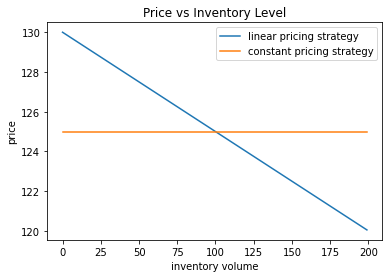

In [ ]:
import matplotlib.pyplot as plt

plt.plot(inventory_level, linear, label='linear pricing strategy')
plt.plot(inventory_level, constant, label='constant pricing strategy')
plt.title('Price vs Inventory Level')
plt.xlabel('inventory volume')
plt.ylabel('price')
plt.legend()

In [ ]:
# Customers Arrival and Demand
customers = Customers(demand_attr=demand_attr, arrival_attr=arrival_attr)
arrival_time = customers.get_arrival()
arrival_func = customers.arrival_function()
time = np.linspace(0, total_day + 1, total_day)

(-2.0, 366.0)

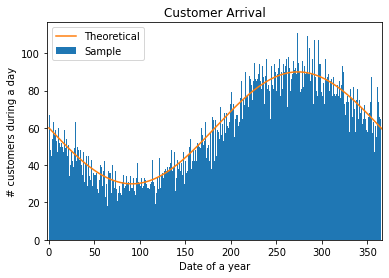

In [ ]:

plt.hist(arrival_time, bins=total_day, label='Sample')
plt.plot(time, arrival_func(time), label='Theoretical')

plt.title('Customer Arrival')
plt.legend()
plt.xlabel('Date of a year')
plt.ylabel('# customers during a day')
plt.xlim(start_time, end_time)



In [ ]:

price = np.arange(0, MAX_PRICE, 0.1)
freshness = np.arange(0, MAX_FRESHNESS, 0.1)
price, freshness = np.meshgrid(price, freshness)

demand_func = customers.demand_function()
max_demand = demand_func(price, freshness)
max_demand = max_demand * (max_demand > 0)



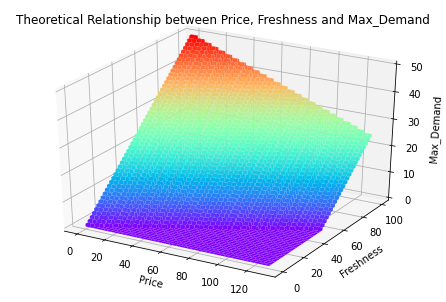

In [ ]:
from mpl_toolkits.mplot3d.axes3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(price, freshness, max_demand, cmap=plt.get_cmap('rainbow'))
ax.set_xlabel('Price')
ax.set_ylabel('Freshness')
ax.set_zlabel('Max_Demand')
plt.title('Theoretical Relationship between Price, Freshness and Max_Demand')
plt.show()


In [ ]:
#hurricane

hurr = Hurricane()
month, dailyAvg = list(hurr.month_freq.keys()), list(hurr.month_freq.values())
monthlyAvg = [d*30 for d in dailyAvg]


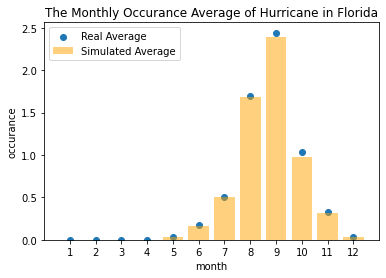

In [ ]:

N = 1000
sample = [list(np.floor(np.array(hurr.hurricane_simulation()) / 30) + 1) for _ in range(N)]
sample = sum(sample, [])


unique, counts = np.unique(sample, return_counts=True)


freq_map = collections.defaultdict(int)
for m in month:
    freq_map[m]
for m, c in zip(unique, counts):
    freq_map[int(m)] = c


plt.bar(month, np.array(list(freq_map.values())) / N, label='Simulated Average', color='orange', alpha=0.5)
plt.scatter(month, monthlyAvg, label='Real Average')
plt.xticks(month)
plt.title('The Monthly Occurance Average of Hurricane in Florida')
plt.ylabel('occurance')
plt.xlabel('month')
plt.legend()
plt.show()


In [ ]:
#inventory simulation
"""
inv = Inventory(debug=True)

def refill_every_ten_days(env, inv):
    while True:
        yield env.timeout(20)
        # refill the orange every 20 days with 30 volume
        inv.refill(env.now, 30)
        print('refill 30 oranges at t=%.2f' % env.now)

def sell_every_ten_days(env, inv):
    while True:
        yield env.timeout(10)
        # selling the orange every 10 days with 8 volume
        print('selling 8 oranges at t=%.2f' % env.now)
        inv.selling(8)

env = simpy.Environment()
env.process(inv.inventory_process(env))
env.process(refill_every_ten_days(env, inv))
env.process(sell_every_ten_days(env, inv))
env.run(until=365)
"""

"\ninv = Inventory(debug=True)\n\ndef refill_every_ten_days(env, inv):\n    while True:\n        yield env.timeout(20)\n        # refill the orange every 20 days with 30 volume\n        inv.refill(env.now, 30)\n        print('refill 30 oranges at t=%.2f' % env.now)\n\ndef sell_every_ten_days(env, inv):\n    while True:\n        yield env.timeout(10)\n        # selling the orange every 10 days with 8 volume\n        print('selling 8 oranges at t=%.2f' % env.now)\n        inv.selling(8)\n\nenv = simpy.Environment()\nenv.process(inv.inventory_process(env))\nenv.process(refill_every_ten_days(env, inv))\nenv.process(sell_every_ten_days(env, inv))\nenv.run(until=365)\n"

In [ ]:
import os
import pickle
import datetime
import itertools
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm

#from main import *
%matplotlib inline

### Experiment Goals
1. pricing strategy: constant price / linear price
2. the effect of hurricane, we assume all hurricane will make a 5 days orange price strike
3. refill strategy: refill our inventory when the inventory volume is only 30%, 15%, or 8%

### basic settings
1. orange price is the `Orange Juice Futures Historical Data.csv`, and we divide the original price by 2
2. we always refill 50 unit of orange
3. our inventory always start with 50 units of orange

### Optimization Goals
1. optimize target: revenue
2. what combination of price strategy and refill level we would recommend

### Following Questions Based on Our Best Strategy
1. how many customers come without buying anything (arrived but demand=0)
2. how many days the inventory level equals to 0
3. how many times we refill the inventory
4. how many times we cannot fulfill customers' demand (the inventory level is smaller than the demand)
5. what is the average orange freshness we sell to our customers
6. how many units of orange are decayed
7. what is the effect of hurricane on the revenue of recommended strategy?

#### Print out all default environment parameters

In [ ]:
get_all_default_parameters()

{'CONSTANT_PRICE': 125,
 'LINEAR_PRICE_BETA': -0.05,
 'MAX_FRESHNESS': 100,
 'MAX_INVENTORY': 200,
 'MAX_PRICE': 130,
 'REFILL_UNIT': 50,
 'STARTING_UNIT': 50,
 'arrival_attr': (30, 2, 60),
 'demand_attr': (-0.2, 100, 200),
 'total_day': 365}

In [ ]:
#parameters
bins = 20
figsize = (10, 6)

Load Orange Price (without Hurricane Effect)

In [ ]:
orange_priceString = '''"Date","Price","Open","High","Low","Vol.","Change %"
"Dec 31, 2019","97.20","94.50","100.10","94.50","0.55K","2.21%"
"Dec 30, 2019","95.10","97.40","97.75","93.25","0.85K","-2.36%"
"Dec 27, 2019","97.40","96.60","98.80","96.30","1.05K","0.83%"
"Dec 26, 2019","96.60","99.60","99.60","95.50","0.69K","-3.30%"
"Dec 25, 2019","99.90","99.90","99.90","99.90","-","0.05%"
"Dec 24, 2019","99.85","100.90","100.90","99.10","0.44K","-1.33%"
"Dec 23, 2019","101.20","100.70","101.50","100.35","1.34K","0.55%"
"Dec 20, 2019","100.65","99.80","101.00","99.60","1.59K","0.90%"
"Dec 19, 2019","99.75","97.75","99.90","97.60","1.57K","2.10%"
"Dec 18, 2019","97.70","97.25","98.15","97.10","1.39K","0.41%"
"Dec 17, 2019","97.30","98.05","98.25","96.65","2.93K","-0.87%"
"Dec 16, 2019","98.15","97.55","98.55","97.25","2.23K","0.82%"
"Dec 13, 2019","97.35","97.40","97.70","96.75","1.36K","-0.10%"
"Dec 12, 2019","97.45","98.40","98.50","97.10","0.89K","-0.81%"
"Dec 11, 2019","98.25","98.30","99.10","97.60","0.71K","-0.61%"
"Dec 10, 2019","98.85","97.55","99.05","97.15","1.30K","1.75%"
"Dec 09, 2019","97.15","95.55","97.40","95.00","1.59K","2.10%"
"Dec 06, 2019","95.15","95.80","95.95","94.75","1.21K","-0.63%"
"Dec 05, 2019","95.75","95.95","96.60","95.50","1.00K","0.31%"
"Dec 04, 2019","95.45","97.20","97.50","95.25","1.14K","-1.24%"
"Dec 03, 2019","96.65","96.30","98.20","96.25","1.38K","0.21%"
"Dec 02, 2019","96.45","98.60","98.90","96.25","1.51K","-2.18%"
"Nov 29, 2019","98.60","99.55","100.00","98.50","0.40K","-1.20%"
"Nov 27, 2019","99.80","100.00","100.30","99.35","0.46K","0.05%"
"Nov 26, 2019","99.75","99.55","100.25","99.30","0.65K","0.20%"
"Nov 25, 2019","99.55","98.50","99.80","98.35","0.50K","1.43%"
"Nov 22, 2019","98.15","98.15","99.15","98.10","0.41K","0.05%"
"Nov 21, 2019","98.10","99.30","100.00","98.00","0.44K","-1.31%"
"Nov 20, 2019","99.40","98.00","99.70","97.90","0.45K","1.27%"
"Nov 19, 2019","98.15","98.50","98.50","97.50","0.53K","-0.41%"
"Nov 18, 2019","98.55","100.55","100.70","98.15","0.73K","-1.94%"
"Nov 15, 2019","100.50","100.30","100.50","100.00","0.32K","0.05%"
"Nov 14, 2019","100.45","100.00","100.55","99.10","0.42K","0.35%"
"Nov 13, 2019","100.10","98.70","100.15","98.25","0.53K","1.57%"
"Nov 12, 2019","98.55","98.30","98.95","97.00","0.64K","0.46%"
"Nov 11, 2019","98.10","100.70","101.65","97.60","0.86K","-2.56%"
"Nov 08, 2019","100.68","99.25","100.68","99.00","-","4.82%"
"Nov 07, 2019","96.05","96.95","96.95","96.95","0.21K","-3.42%"
"Nov 06, 2019","99.45","100.43","100.80","99.05","-","-1.04%"
"Nov 05, 2019","100.50","100.03","100.60","99.60","-","5.57%"
"Nov 04, 2019","95.20","95.00","95.95","95.00","0.01K","0.05%"
"Nov 01, 2019","95.15","96.00","96.00","96.00","0.01K","-0.73%"
"Oct 31, 2019","95.85","94.65","96.40","93.60","0.28K","0.79%"
"Oct 30, 2019","95.10","94.80","95.45","92.60","0.76K","0.42%"
"Oct 29, 2019","94.70","94.10","95.00","93.40","0.94K","1.39%"
"Oct 28, 2019","93.40","98.15","98.80","93.05","1.04K","-4.74%"
"Oct 25, 2019","98.05","97.65","98.55","96.75","0.75K","0.26%"
"Oct 24, 2019","97.80","98.10","99.00","97.50","0.73K","-0.41%"
"Oct 23, 2019","98.20","97.65","98.60","97.40","0.97K","0.26%"
"Oct 22, 2019","97.95","98.35","98.70","97.65","1.33K","-0.20%"
"Oct 21, 2019","98.15","99.35","100.15","97.85","1.48K","-1.21%"
"Oct 18, 2019","99.35","99.55","99.90","98.60","1.59K","-0.45%"
"Oct 17, 2019","99.80","100.80","101.25","99.20","1.69K","-0.65%"
"Oct 16, 2019","100.45","99.55","101.15","99.55","1.68K","0.30%"
"Oct 15, 2019","100.15","99.50","101.00","99.05","1.07K","0.75%"
"Oct 14, 2019","99.40","96.95","99.75","96.95","1.30K","2.05%"
"Oct 11, 2019","97.40","97.10","97.95","96.80","0.73K","0.41%"
"Oct 10, 2019","97.00","99.30","99.70","96.70","0.91K","-0.77%"
"Oct 09, 2019","97.75","101.80","102.45","97.25","1.14K","-4.45%"
"Oct 08, 2019","102.30","103.45","104.50","101.25","1.10K","-1.11%"
"Oct 07, 2019","103.45","99.85","103.70","99.85","1.01K","3.40%"
"Oct 04, 2019","100.05","100.00","100.30","99.50","0.58K","0.15%"
"Oct 03, 2019","99.90","99.65","100.35","99.25","0.55K","0.81%"
"Oct 02, 2019","99.10","99.25","99.75","98.65","0.47K","0.35%"
"Oct 01, 2019","98.75","99.90","99.95","98.05","0.77K","-1.00%"
"Sep 30, 2019","99.75","100.05","100.10","98.30","0.49K","-0.10%"
"Sep 27, 2019","99.85","97.55","100.00","97.55","0.87K","2.41%"
"Sep 26, 2019","97.50","96.80","98.05","96.50","0.75K","0.52%"
"Sep 25, 2019","97.00","98.90","99.05","96.05","1.08K","-1.27%"
"Sep 24, 2019","98.25","99.70","100.40","98.15","0.49K","-1.85%"
"Sep 23, 2019","100.10","100.50","100.60","99.10","0.30K","-0.05%"
"Sep 20, 2019","100.15","99.00","101.05","99.00","0.67K","1.52%"
"Sep 19, 2019","98.65","99.15","99.90","98.00","0.54K","-0.45%"
"Sep 18, 2019","99.10","101.00","101.10","98.70","0.50K","-1.74%"
"Sep 17, 2019","100.85","102.40","102.70","100.35","0.52K","-1.18%"
"Sep 16, 2019","102.05","102.20","103.55","101.75","0.41K","0.10%"
"Sep 13, 2019","101.95","103.00","103.05","101.70","0.47K","-1.02%"
"Sep 12, 2019","103.00","104.05","105.00","102.65","0.45K","-2.14%"
"Sep 11, 2019","105.25","104.05","105.50","103.20","0.70K","1.22%"
"Sep 10, 2019","103.98","101.60","104.15","101.60","-","2.41%"
"Sep 09, 2019","101.53","101.85","103.22","101.20","-","-0.34%"
"Sep 06, 2019","101.88","103.93","104.08","101.70","-","-2.04%"
"Sep 05, 2019","104.00","104.50","104.50","104.50","0.00K","1.71%"
"Sep 04, 2019","102.25","99.03","103.50","98.65","-","4.55%"
"Sep 03, 2019","97.80","97.05","97.05","94.50","0.03K","-2.69%"
"Aug 30, 2019","100.50","106.00","106.90","101.00","0.45K","-3.87%"
"Aug 29, 2019","104.55","103.00","105.70","102.45","1.20K","2.25%"
"Aug 28, 2019","102.25","99.00","102.35","99.00","0.65K","3.02%"
"Aug 27, 2019","99.25","98.50","99.50","97.75","0.86K","0.76%"
"Aug 26, 2019","98.50","95.50","99.25","95.50","0.92K","2.55%"
"Aug 23, 2019","96.05","96.00","97.45","95.50","0.93K","-0.93%"
"Aug 22, 2019","96.95","98.50","98.50","95.85","0.73K","-0.97%"
"Aug 21, 2019","97.90","96.05","98.60","95.10","1.17K","2.30%"
"Aug 20, 2019","95.70","94.80","96.20","93.90","1.97K","1.38%"
"Aug 19, 2019","94.40","98.70","100.00","92.70","2.83K","-4.45%"
"Aug 16, 2019","98.80","97.60","100.40","96.15","2.08K","1.23%"
"Aug 15, 2019","97.60","98.90","98.95","97.00","0.93K","-1.21%"
"Aug 14, 2019","98.80","98.95","100.10","98.45","0.55K","0.00%"
"Aug 13, 2019","98.80","99.30","99.95","98.40","0.79K","-0.05%"
"Aug 12, 2019","98.85","101.70","102.80","98.35","0.83K","-3.37%"
"Aug 09, 2019","102.30","101.50","102.65","100.20","0.47K","0.49%"
"Aug 08, 2019","101.80","100.90","103.15","100.90","0.66K","0.79%"
"Aug 07, 2019","101.00","102.90","103.20","100.55","0.58K","-1.85%"
"Aug 06, 2019","102.90","99.00","103.00","97.80","1.35K","4.47%"
"Aug 05, 2019","98.50","98.75","99.20","95.85","1.11K","-0.71%"
"Aug 02, 2019","99.20","100.45","100.50","98.20","1.05K","-1.49%"
"Aug 01, 2019","100.70","103.45","103.45","100.25","0.88K","-2.66%"
"Jul 31, 2019","103.45","102.30","103.80","101.75","0.54K","1.07%"
"Jul 30, 2019","102.35","102.60","103.85","102.10","0.64K","0.64%"
"Jul 29, 2019","101.70","102.30","102.85","100.95","0.59K","-0.73%"
"Jul 26, 2019","102.45","104.25","104.25","101.75","0.46K","-1.63%"
"Jul 25, 2019","104.15","104.00","104.30","103.25","0.52K","0.24%"
"Jul 24, 2019","103.90","101.75","104.10","101.75","0.58K","2.36%"
"Jul 23, 2019","101.50","103.25","103.25","101.25","0.46K","-1.50%"
"Jul 22, 2019","103.05","103.80","104.00","102.30","0.34K","-1.01%"
"Jul 19, 2019","104.10","101.00","104.60","101.00","0.97K","3.58%"
"Jul 18, 2019","100.50","102.95","102.95","100.40","0.83K","-2.47%"
"Jul 17, 2019","103.05","104.55","104.60","101.50","0.42K","-1.58%"
"Jul 16, 2019","104.70","101.95","104.90","101.95","0.83K","3.41%"
"Jul 15, 2019","101.25","103.50","103.90","101.00","0.68K","-2.08%"
"Jul 12, 2019","103.40","102.60","104.35","102.55","0.61K","0.88%"
"Jul 11, 2019","102.50","103.15","103.48","102.30","-","-0.73%"
"Jul 10, 2019","103.25","103.82","104.70","103.05","-","-0.08%"
"Jul 09, 2019","103.33","105.65","105.75","101.80","-","-1.71%"
"Jul 08, 2019","105.13","102.30","105.73","102.20","-","2.57%"
"Jul 05, 2019","102.50","101.35","102.70","100.95","-","1.59%"
"Jul 03, 2019","100.90","100.25","101.60","98.90","-","5.21%"
"Jul 02, 2019","95.90","98.00","98.00","96.00","0.00K","-2.44%"
"Jul 01, 2019","98.30","101.90","101.90","98.00","0.02K","-2.63%"
"Jun 28, 2019","100.95","99.45","101.65","99.45","0.21K","1.66%"
"Jun 27, 2019","99.30","99.00","100.30","97.70","0.97K","0.40%"
"Jun 26, 2019","98.90","100.65","101.40","98.00","0.69K","-1.64%"
"Jun 25, 2019","100.55","99.85","102.30","99.85","0.75K","1.31%"
"Jun 24, 2019","99.25","99.85","100.25","96.90","1.20K","-0.75%"
"Jun 21, 2019","100.00","99.95","100.60","99.55","0.78K","0.20%"
"Jun 20, 2019","99.80","99.10","101.25","98.00","1.73K","1.01%"
"Jun 19, 2019","98.80","101.80","102.10","98.10","1.55K","-2.85%"
"Jun 18, 2019","101.70","104.35","105.30","101.05","1.78K","-2.91%"
"Jun 17, 2019","104.75","104.45","105.95","104.20","1.74K","0.24%"
"Jun 14, 2019","104.50","104.45","105.10","103.25","1.20K","1.70%"
"Jun 13, 2019","102.75","101.20","104.05","101.15","1.03K","1.18%"
"Jun 12, 2019","101.55","103.50","104.50","100.70","1.15K","-1.84%"
"Jun 11, 2019","103.45","101.65","103.90","100.35","1.31K","1.77%"
"Jun 10, 2019","101.65","106.10","107.35","100.25","0.92K","-4.19%"
"Jun 07, 2019","106.10","107.25","107.80","105.10","0.41K","-1.12%"
"Jun 06, 2019","107.30","103.55","108.00","102.15","0.79K","3.42%"
"Jun 05, 2019","103.75","108.45","109.75","103.40","1.13K","-4.42%"
"Jun 04, 2019","108.55","111.20","112.60","107.00","1.12K","-2.12%"
"Jun 03, 2019","110.90","108.25","111.50","106.95","1.15K","2.31%"
"May 31, 2019","108.40","104.80","108.75","104.70","1.34K","3.68%"
"May 30, 2019","104.55","104.25","105.55","104.00","0.59K","1.31%"
"May 29, 2019","103.20","104.80","106.05","102.65","0.72K","-1.15%"
"May 28, 2019","104.40","100.85","105.05","100.85","0.76K","3.42%"
"May 24, 2019","100.95","99.70","101.50","98.50","0.54K","1.25%"
"May 23, 2019","99.70","98.45","101.95","98.45","0.70K","1.53%"
"May 22, 2019","98.20","98.50","101.30","97.95","0.43K","0.20%"
"May 21, 2019","98.00","99.65","99.75","95.10","0.67K","-2.24%"
"May 20, 2019","100.25","97.95","101.50","96.85","0.70K","3.62%"
"May 17, 2019","96.75","102.55","102.75","96.40","1.19K","-5.61%"
"May 16, 2019","102.50","106.75","107.50","102.25","1.39K","-4.12%"
"May 15, 2019","106.90","102.10","107.80","102.10","2.09K","5.11%"
"May 14, 2019","101.70","96.70","102.50","96.70","1.32K","6.16%"
"May 13, 2019","95.80","95.70","96.90","95.35","0.73K","-0.24%"
"May 10, 2019","96.03","93.60","96.53","93.30","-","2.62%"
"May 09, 2019","93.58","94.25","94.25","91.90","-","-0.55%"
"May 08, 2019","94.10","90.75","95.10","90.75","-","3.12%"
"May 07, 2019","91.25","92.25","92.50","92.25","0.00K","-0.71%"
"May 06, 2019","91.90","91.00","91.00","91.00","0.01K","-1.64%"
"May 03, 2019","93.43","93.82","94.53","93.30","-","0.52%"
"May 02, 2019","92.95","95.55","95.55","93.25","0.08K","-1.17%"
"May 01, 2019","94.05","95.15","95.15","90.30","0.07K","-0.79%"
"Apr 30, 2019","94.80","96.65","97.15","91.00","0.56K","-1.96%"
"Apr 29, 2019","96.70","99.85","99.85","96.50","0.65K","-3.11%"
"Apr 26, 2019","99.80","101.00","101.25","99.25","1.01K","-0.94%"
"Apr 25, 2019","100.75","100.40","102.40","100.40","0.83K","0.30%"
"Apr 24, 2019","100.45","101.35","102.75","99.85","1.12K","-0.54%"
"Apr 23, 2019","101.00","106.10","106.35","100.20","1.04K","-4.76%"
"Apr 22, 2019","106.05","107.00","107.20","105.90","0.37K","-1.12%"
"Apr 18, 2019","107.25","109.80","110.40","107.00","1.00K","-2.19%"
"Apr 17, 2019","109.65","107.80","110.15","107.70","1.59K","2.05%"
"Apr 16, 2019","107.45","110.50","110.50","106.60","2.12K","-2.18%"
"Apr 15, 2019","109.85","106.75","111.45","106.50","1.49K","2.95%"
"Apr 12, 2019","106.70","107.15","108.00","105.40","1.48K","-0.42%"
"Apr 11, 2019","107.15","108.20","109.35","106.45","1.17K","-1.34%"
"Apr 10, 2019","108.60","108.90","109.80","108.20","1.52K","-0.73%"
"Apr 09, 2019","109.40","111.55","112.50","107.65","1.77K","-1.84%"
"Apr 08, 2019","111.45","116.30","116.85","110.55","2.40K","-4.54%"
"Apr 05, 2019","116.75","117.70","118.80","116.35","1.03K","-0.81%"
"Apr 04, 2019","117.70","120.20","120.40","117.65","1.33K","-2.24%"
"Apr 03, 2019","120.40","122.50","123.20","119.75","0.48K","-1.03%"
"Apr 02, 2019","121.65","123.25","124.95","121.50","0.59K","-1.58%"
"Apr 01, 2019","123.60","120.15","124.95","120.15","0.88K","3.09%"
"Mar 29, 2019","119.90","122.75","123.90","119.50","0.95K","-3.15%"
"Mar 28, 2019","123.80","123.50","124.50","120.80","0.94K","0.65%"
"Mar 27, 2019","123.00","129.10","129.35","120.40","1.16K","-4.28%"
"Mar 26, 2019","128.50","128.55","129.65","128.00","1.38K","-0.27%"
"Mar 25, 2019","128.85","128.65","130.50","127.40","1.33K","-0.77%"
"Mar 22, 2019","129.85","127.00","130.00","125.50","0.91K","1.84%"
"Mar 21, 2019","127.50","130.15","131.00","127.05","1.63K","-2.00%"
"Mar 20, 2019","130.10","129.35","130.15","129.30","0.87K","0.66%"
"Mar 19, 2019","129.25","128.50","129.40","128.50","0.90K","0.58%"
"Mar 18, 2019","128.50","126.25","129.05","126.20","1.07K","1.66%"
"Mar 15, 2019","126.40","125.00","126.50","124.55","0.61K","1.20%"
"Mar 14, 2019","124.90","123.50","126.00","123.50","1.07K","1.17%"
"Mar 13, 2019","123.45","124.50","127.85","122.75","2.01K","-0.04%"
"Mar 12, 2019","123.50","118.25","124.45","118.25","1.82K","9.34%"
"Mar 11, 2019","112.95","110.90","113.85","110.70","0.01K","1.26%"
"Mar 08, 2019","111.55","111.70","111.70","111.25","0.00K","-0.36%"
"Mar 07, 2019","111.95","111.95","111.95","111.90","0.00K","-0.22%"
"Mar 06, 2019","112.20","112.90","113.10","112.90","0.01K","-0.40%"
"Mar 05, 2019","112.65","113.80","113.80","112.75","0.15K","-1.49%"
"Mar 04, 2019","114.35","113.75","114.00","113.70","0.01K","0.26%"
"Mar 01, 2019","114.05","114.55","114.75","113.75","0.11K","-0.22%"
"Feb 28, 2019","114.30","112.95","114.25","112.15","0.71K","1.02%"
"Feb 27, 2019","113.15","116.25","116.25","113.00","0.88K","-3.00%"
"Feb 26, 2019","116.65","118.15","118.15","116.10","0.94K","-1.52%"
"Feb 25, 2019","118.45","120.65","121.25","118.10","0.93K","-2.35%"
"Feb 22, 2019","121.30","119.65","121.90","118.95","1.32K","1.04%"
"Feb 21, 2019","120.05","119.35","120.40","118.50","0.73K","0.17%"
"Feb 20, 2019","119.85","118.50","120.70","118.20","1.24K","0.88%"
"Feb 19, 2019","118.80","115.85","119.00","115.25","2.55K","3.13%"
"Feb 15, 2019","115.20","117.85","118.85","115.00","1.94K","-2.12%"
"Feb 14, 2019","117.70","119.20","119.30","117.00","2.36K","-1.18%"
"Feb 13, 2019","119.10","119.80","119.80","118.95","1.41K","0.17%"
"Feb 12, 2019","118.90","118.35","119.90","118.35","1.58K","0.46%"
"Feb 11, 2019","118.35","121.15","121.45","118.25","1.13K","-2.15%"
"Feb 08, 2019","120.95","120.15","121.20","119.80","0.65K","0.92%"
"Feb 07, 2019","119.85","119.30","120.55","118.95","0.61K","-0.50%"
"Feb 06, 2019","120.45","120.00","121.50","119.85","0.54K","0.37%"
"Feb 05, 2019","120.00","119.20","121.00","118.95","0.61K","0.80%"
"Feb 04, 2019","119.05","121.60","122.00","118.80","1.20K","-2.62%"
"Feb 01, 2019","122.25","120.00","122.65","119.50","1.08K","1.79%"
"Jan 31, 2019","120.10","116.80","120.80","116.50","1.14K","2.65%"
"Jan 30, 2019","117.00","116.50","117.20","116.05","0.81K","-0.38%"
"Jan 29, 2019","117.45","117.95","118.20","115.90","0.76K","-0.76%"
"Jan 28, 2019","118.35","119.70","119.75","117.75","0.44K","-0.88%"
"Jan 25, 2019","119.40","118.45","120.00","118.00","0.43K","0.21%"
"Jan 24, 2019","119.15","117.80","119.65","117.00","0.95K","1.06%"
"Jan 23, 2019","117.90","119.25","119.90","117.65","0.58K","-1.09%"
"Jan 22, 2019","119.20","120.00","121.20","118.40","1.01K","-0.54%"
"Jan 18, 2019","119.85","119.60","121.30","119.40","0.62K","0.29%"
"Jan 17, 2019","119.50","120.50","120.80","119.00","0.47K","-1.16%"
"Jan 16, 2019","120.90","121.85","121.95","119.70","0.76K","-0.41%"
"Jan 15, 2019","121.40","121.50","123.00","121.00","0.79K","0.54%"
"Jan 14, 2019","120.75","120.90","123.50","118.65","1.06K","-0.21%"
"Jan 11, 2019","121.00","122.60","122.95","120.70","0.73K","-1.05%"
"Jan 10, 2019","122.28","125.20","125.25","122.10","-","-1.03%"
"Jan 09, 2019","123.55","121.70","124.45","121.70","0.00K","1.02%"
"Jan 08, 2019","122.30","123.50","123.50","123.50","0.00K","0.29%"
"Jan 07, 2019","121.95","121.20","122.00","121.15","0.05K","0.54%"
"Jan 04, 2019","121.30","121.00","121.00","120.40","0.06K","-0.29%"
"Jan 03, 2019","121.65","125.70","125.70","124.25","0.01K","-0.61%"
"Jan 02, 2019","122.40","122.95","123.35","122.75","0.01K","-2.20%"
"Jan 01, 2019","122.40","122.95","123.35","122.75","0.01K","-2.20%"'''

In [ ]:
df = load_orange_price(orange_priceString)
orange_price = get_orange_price(df, return_origin=True, seed=0)
orange_price.head()

,Price,Strike,Final Price
0,61.20,0.0,61.20
1,61.20,0.0,61.20
2,60.82,0.0,60.82
3,60.65,0.0,60.65
4,60.65,0.0,60.65


Text(0.5, 0, 'date')

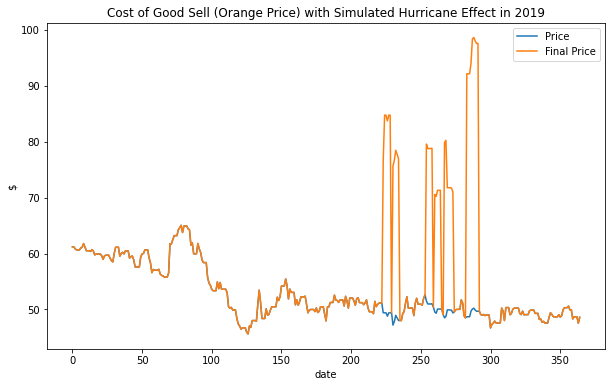

In [ ]:
orange_price[['Price', 'Final Price']].plot(figsize=(10, 6))
plt.title('Cost of Good Sell (Orange Price) with Simulated Hurricane Effect in 2019')
plt.ylabel('$')
plt.xlabel('date')

#### Experiments

In [ ]:
#### Experiments

In [ ]:
N = 1000
strategyList = ['constant', 'linear']
refill_percentage = [0.30, 0.15, 0.08]

best_profit = float("-inf")
best_strategy = (None, None)
best_result = None

In [ ]:
list(itertools.product(strategyList, refill_percentage))

[('constant', 0.3),
 ('constant', 0.15),
 ('constant', 0.08),
 ('linear', 0.3),
 ('linear', 0.15),
 ('linear', 0.08)]

In [ ]:
logPath = os.getcwd() + '/log.txt'

In [ ]:
set_seed = False

In [ ]:
logFile = open(logPath, 'w')

for s, r in tqdm(itertools.product(strategyList, refill_percentage), "All", ncols=300, position=0):
    
    resultList = []
    for seed in tqdm(range(N), "Sub", ncols=300, position=1, leave=False):
        logMessage = '%s, %.2f, %s\n'
        logFile.write(logMessage % (s, r, str(seed)))
        if not set_seed:
            seed = None
        
        df = load_orange_price(orange_priceString)
        orange_price = get_orange_price(df, seed=seed)
        resultList.append( system(orange_price, strategy=s, refill_percentage=r, seed=seed) )
    
    result = getAverageResult(*resultList)
    logMessage = '='*20 + '\n'
    logFile.write(logMessage)
    print('when strategy=%s \t refill_percentage=%.2f, \tthe average profit is %.2f\n' % (s, r, result['avgProfit']))

    if result['avgProfit'] > best_profit:
        best_profit = result['avgProfit']
        best_strategy = (s, r)
        best_result = result
        
        
logFile.close()

when strategy=constant 	 refill_percentage=0.30, 	the average profit is 7020.93



when strategy=constant 	 refill_percentage=0.15, 	the average profit is 63503.27



when strategy=constant 	 refill_percentage=0.08, 	the average profit is 78690.35



when strategy=linear 	 refill_percentage=0.30, 	the average profit is 8127.32



when strategy=linear 	 refill_percentage=0.15, 	the average profit is 65230.66



when strategy=linear 	 refill_percentage=0.08, 	the average profit is 81884.15




In [40]:
resultFileName = os.getcwd() + '/strategy=%s&refill_perct=%.f&'
resultFileName += datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
resultFileName += '.pkl'

print('the result is stored in pickle file: %s' % resultFileName)
with open(resultFileName % (best_strategy[0], best_strategy[1] * 100), 'wb') as handle:
    pickle.dump(best_result, handle, protocol=pickle.HIGHEST_PROTOCOL)

the result is stored in pickle file: /content/strategy=%s&refill_perct=%.f&2020-12-24 06:07:46.pkl


In [41]:
best_strategy, best_profit

(('linear', 0.08), 82582.89382776561)

Revenue 0.95 confidence interval: (197789.707, 200169.502)
Cost 0.95 confidence interval: (115909.897, 116883.524)


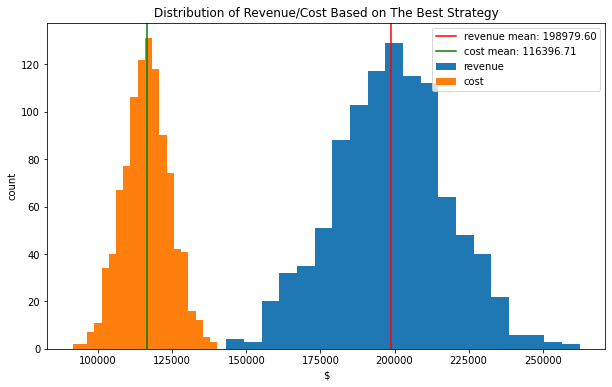

In [42]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
plt.hist(best_result['Revenue'], bins=bins, label='revenue')
plt.hist(best_result['Cost'], bins=bins, label='cost')
ax.axvline(best_result['avgRevenue'], color='red', label='revenue mean: %.2f' % best_result['avgRevenue'])
ax.axvline(best_result['avgCost'], color='green', label='cost mean: %.2f' % best_result['avgCost'])
plt.title('Distribution of Revenue/Cost Based on The Best Strategy')
plt.ylabel('count')
plt.xlabel('$')
plt.legend()

calculateConfidenceInterval(best_result['Revenue'], names='Revenue')
calculateConfidenceInterval(best_result['Cost'], names='Cost')

Profit 0.95 confidence interval: (81828.452, 83337.336)


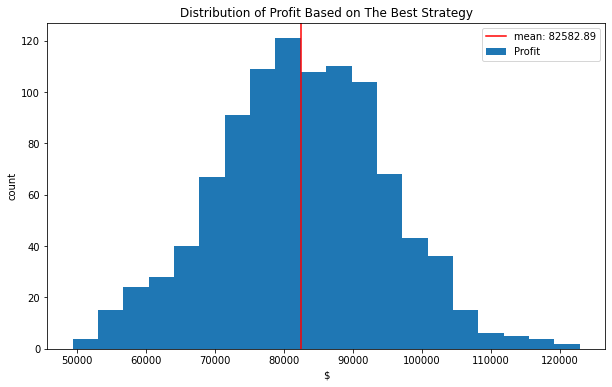

In [43]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
plt.hist(best_result['Profit'], bins=bins, label='Profit')
ax.axvline(best_result['avgProfit'], color='red', label='mean: %.2f' % best_result['avgProfit'])
plt.title('Distribution of Profit Based on The Best Strategy')
plt.ylabel('count')
plt.xlabel('$')
plt.legend()

calculateConfidenceInterval(best_result['Profit'], names='Profit')

1. how many customers come without buying anything (arrived but demand=0)

Zero Demand Arrival 0.95 confidence interval: (0.266, 0.27)


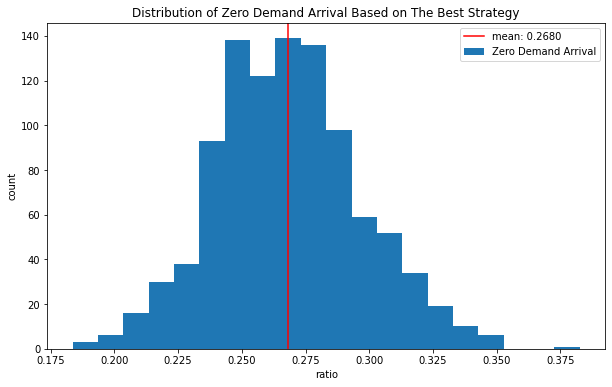

In [44]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
plt.hist(best_result['CustomerZeroDemand'], bins=bins, label='Zero Demand Arrival')
ax.axvline(best_result['avgCustomerZeroDemand'], color='red', label='mean: %.4f' % best_result['avgCustomerZeroDemand'])
plt.title('Distribution of Zero Demand Arrival Based on The Best Strategy')
plt.ylabel('count')
plt.xlabel('ratio')
plt.legend()

calculateConfidenceInterval(best_result['CustomerZeroDemand'], names='Zero Demand Arrival')

2. how many days the inventory level equals to 0

Zero Inventory Level 0.95 confidence interval: (0.061, 0.062)


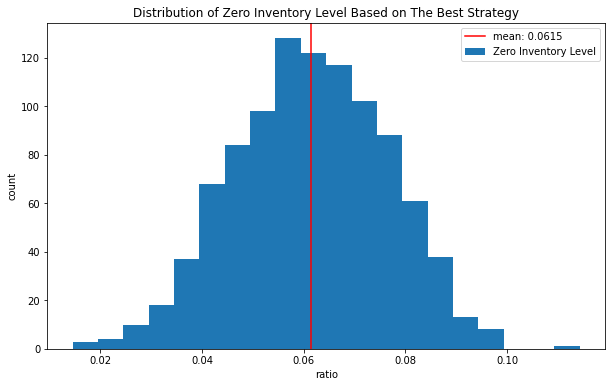

In [45]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
plt.hist(best_result['ZeroInventoryLevel'], bins=bins, label='Zero Inventory Level')
ax.axvline(best_result['avgZeroInventoryLevel'], color='red', label='mean: %.4f' % best_result['avgZeroInventoryLevel'])
plt.title('Distribution of Zero Inventory Level Based on The Best Strategy')
plt.ylabel('count')
plt.xlabel('ratio')
plt.legend()

calculateConfidenceInterval(best_result['ZeroInventoryLevel'], names='Zero Inventory Level')

3. how many times we refill the inventory

Refill Times 0.95 confidence interval: (40.944, 41.27)


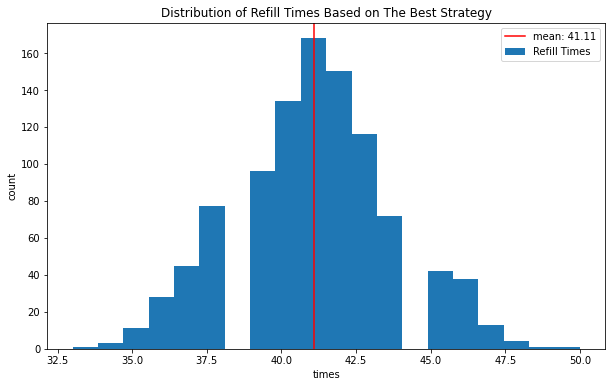

In [46]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
plt.hist(best_result['RefillTimes'], bins=bins, label='Refill Times')
ax.axvline(best_result['avgRefillTimes'], color='red', label='mean: %.2f' % best_result['avgRefillTimes'])
plt.title('Distribution of Refill Times Based on The Best Strategy')
plt.ylabel('count')
plt.xlabel('times')
plt.legend()

calculateConfidenceInterval(best_result['RefillTimes'], names='Refill Times')

4. how many times we cannot fulfill customers' demand (the inventory level is smaller than the demand)

Not Fulfill Ratio 0.95 confidence interval: (0.087, 0.09)


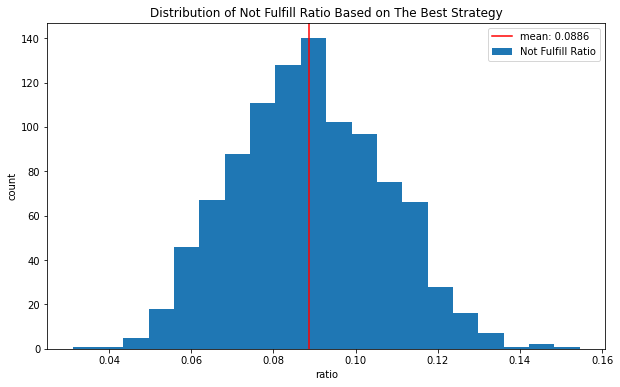

In [47]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
plt.hist(best_result['NotFulfillRatio'], bins=bins, label='Not Fulfill Ratio')
ax.axvline(best_result['avgNotFulfillRatio'], color='red', label='mean: %.4f' % best_result['avgNotFulfillRatio'])
plt.title('Distribution of Not Fulfill Ratio Based on The Best Strategy')
plt.ylabel('count')
plt.xlabel('ratio')
plt.legend()

calculateConfidenceInterval(best_result['NotFulfillRatio'], names='Not Fulfill Ratio')

5. what is the average orange freshness we sell to our customers

Freshness 0.95 confidence interval: (74.53, 74.799)


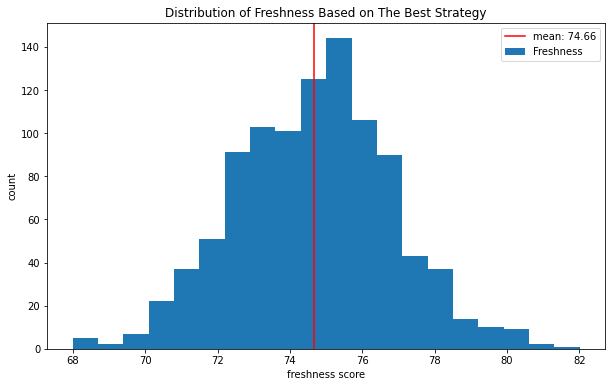

In [48]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
plt.hist(best_result['Freshness'], bins=bins, label='Freshness')
ax.axvline(best_result['avgFreshness'], color='red', label='mean: %.2f' % best_result['avgFreshness'])
plt.title('Distribution of Freshness Based on The Best Strategy')
plt.ylabel('count')
plt.xlabel('freshness score')
plt.legend()

calculateConfidenceInterval(best_result['Freshness'], names='Freshness')

6. how many units of orange are decayed

Decay Units 0.95 confidence interval: (461.956, 466.974)


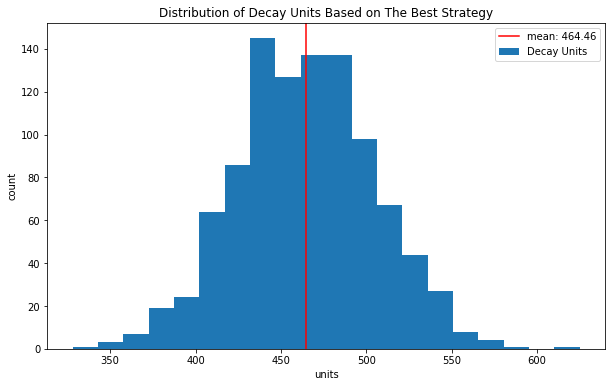

In [49]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
plt.hist(best_result['DecayUnits'], bins=bins, label='Decay Units')
ax.axvline(best_result['avgDecayUnits'], color='red', label='mean: %.2f' % best_result['avgDecayUnits'])
plt.title('Distribution of Decay Units Based on The Best Strategy')
plt.ylabel('count')
plt.xlabel('units')
plt.legend()

calculateConfidenceInterval(best_result['DecayUnits'], names='Decay Units')

7. what is the effect of hurricane on the revenue of recommended strategy?

In [51]:
withHurricane = []
withoutHurricane = []

s = best_strategy[0]
r = best_strategy[1]

for seed in tqdm(range(N)):
    if not set_seed:
        seed = None

    #df = load_orange_price()
    orange_price = get_orange_price(df, return_origin=True, seed=seed)
    withHurricane.append( system(orange_price['Final Price'], strategy=s, refill_percentage=r, seed=seed) )
    withoutHurricane.append( system(orange_price['Price'], strategy=s, refill_percentage=r, seed=seed) )

In [52]:
wh = getAverageResult(*withHurricane)
woh = getAverageResult(*withoutHurricane)

Profit with hurricane 0.95 confidence interval: (81437.105, 82972.752)
Profit withOut hurricane 0.95 confidence interval: (83493.108, 84997.871)


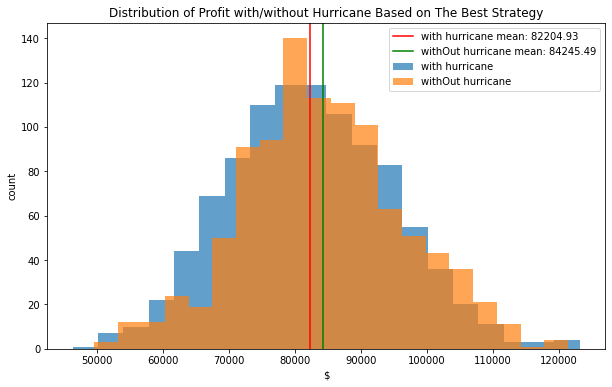

In [53]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
plt.hist(wh['Profit'], bins=bins, label='with hurricane', alpha=0.7)
plt.hist(woh['Profit'], bins=bins, label='withOut hurricane', alpha=0.7)
ax.axvline(wh['avgProfit'], color='red', label='with hurricane mean: %.2f' % wh['avgProfit'])
ax.axvline(woh['avgProfit'], color='green', label='withOut hurricane mean: %.2f' % woh['avgProfit'])
plt.title('Distribution of Profit with/without Hurricane Based on The Best Strategy')
plt.ylabel('count')
plt.xlabel('$')
plt.legend()

calculateConfidenceInterval(wh['Profit'], names='Profit with hurricane')
calculateConfidenceInterval(woh['Profit'], names='Profit withOut hurricane')